<a href="https://colab.research.google.com/github/Kevoharvey/BaseModelForHousingPrices/blob/main/FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Regression Comparison
## Comparing Random Forest, ANN, XGBoost, and CatBoost

This notebook implements and compares different regression algorithms on housing price data:
1. Random Forest Regressor
2. XGBoost
3. CatBoost
4. Artificial Neural Network (Keras)
5. Linear Regression

## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error , accuracy_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Prepare Data

In [4]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Separate target variable
y = train_df['SalePrice']

# Select numerical features excluding 'Id' and 'SalePrice'
numerical_features = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in ['Id', 'SalePrice']]

# Prepare feature sets
X = train_df[numerical_features].copy()
X_test_full = test_df[numerical_features].copy()

# Handle missing values - fill with median
for col in X.columns:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        X_test_full[col] = X_test_full[col].fillna(median_val)

print(f"\nFeatures selected: {len(numerical_features)}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)

Features selected: 36


## Remove Outliers

## 3. Split and Scale Data

In [5]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1168
Validation set size: 292


## 4. Train Models

### 4.1 Random Forest Regressor

In [6]:
print("Training Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
)

rf_model.fit(X_train, y_train)

# Predictions
rf_pred_train = rf_model.predict(X_train)
rf_pred_val = rf_model.predict(X_val)

# Calculate metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_pred_train))
rf_val_rmse = np.sqrt(mean_squared_error(y_val, rf_pred_val))
rf_train_r2 = r2_score(y_train, rf_pred_train)
rf_val_r2 = r2_score(y_val, rf_pred_val)

print(f"\n✓ Random Forest Results:")
print(f"  Train RMSE: ${rf_train_rmse:,.2f}")
print(f"  Val RMSE: ${rf_val_rmse:,.2f}")
print(f"  Train R²: {rf_train_r2:.4f}")
print(f"  Val R²: {rf_val_r2:.4f}")


Training Random Forest Regressor...

✓ Random Forest Results:
  Train RMSE: $14,014.84
  Val RMSE: $29,449.83
  Train R²: 0.9671
  Val R²: 0.8869


### 4.2 XGBoost

In [7]:
print("Training XGBoost...")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_val = xgb_model.predict(X_val)

# Calculate metrics
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_pred_train))
xgb_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred_val))
xgb_train_r2 = r2_score(y_train, xgb_pred_train)
xgb_val_r2 = r2_score(y_val, xgb_pred_val)

print(f"\n✓ XGBoost Results:")
print(f"  Train RMSE: ${xgb_train_rmse:,.2f}")
print(f"  Val RMSE: ${xgb_val_rmse:,.2f}")
print(f"  Train R²: {xgb_train_r2:.4f}")
print(f"  Val R²: {xgb_val_r2:.4f}")

Training XGBoost...

✓ XGBoost Results:
  Train RMSE: $2,327.45
  Val RMSE: $27,449.09
  Train R²: 0.9991
  Val R²: 0.9018


### 4.3 Artificial Neural Network (Keras)

In [8]:
print("Training Keras ANN...")

# Build model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

ann_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train
history = ann_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=0
)

# Predictions
ann_pred_train = ann_model.predict(X_train_scaled).flatten()
ann_pred_val = ann_model.predict(X_val_scaled).flatten()

# Calculate metrics
ann_train_rmse = np.sqrt(mean_squared_error(y_train, ann_pred_train))
ann_val_rmse = np.sqrt(mean_squared_error(y_val, ann_pred_val))
ann_train_r2 = r2_score(y_train, ann_pred_train)
ann_val_r2 = r2_score(y_val, ann_pred_val)

print(f"\n✓ Keras ANN Results:")
print(f"  Train RMSE: ${ann_train_rmse:,.2f}")
print(f"  Val RMSE: ${ann_val_rmse:,.2f}")
print(f"  Train R²: {ann_train_r2:.4f}")
print(f"  Val R²: {ann_val_r2:.4f}")

Training Keras ANN...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

✓ Keras ANN Results:
  Train RMSE: $22,337.95
  Val RMSE: $33,191.32
  Train R²: 0.9163
  Val R²: 0.8564


### 4.4 Linear Regression

In [9]:
print("Training Linear Regression...")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_pred_train = lr_model.predict(X_train)
lr_pred_val = lr_model.predict(X_val)

# Calculate metrics
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_pred_train))
lr_val_rmse = np.sqrt(mean_squared_error(y_val, lr_pred_val))
lr_train_r2 = r2_score(y_train, lr_pred_train)
lr_val_r2 = r2_score(y_val, lr_pred_val)

print(f"\n✓ Linear Regression Results:")
print(f"  Train RMSE: ${lr_train_rmse:,.2f}")
print(f"  Val RMSE: ${lr_val_rmse:,.2f}")
print(f"  Train R²: {lr_train_r2:.4f}")
print(f"  Val R²: {lr_val_r2:.4f}")

Training Linear Regression...

✓ Linear Regression Results:
  Train RMSE: $33,920.14
  Val RMSE: $36,836.91
  Train R²: 0.8071
  Val R²: 0.8231


## 5. Model Comparison

In [10]:
# Create comparison DataFrame
comparison_data = [
    {
        'Model': 'Random Forest',
        'Train RMSE': rf_train_rmse,
        'Val RMSE': rf_val_rmse,
        'Train MAE': mean_absolute_error(y_train, rf_pred_train),
        'Val MAE': mean_absolute_error(y_val, rf_pred_val),
        'Train R2': rf_train_r2,
        'Val R2': rf_val_r2
    },
    {
        'Model': 'XGBoost',
        'Train RMSE': xgb_train_rmse,
        'Val RMSE': xgb_val_rmse,
        'Train MAE': mean_absolute_error(y_train, xgb_pred_train),
        'Val MAE': mean_absolute_error(y_val, xgb_pred_val),
        'Train R2': xgb_train_r2,
        'Val R2': xgb_val_r2
    },
    {
        'Model': 'Keras ANN',
        'Train RMSE': ann_train_rmse,
        'Val RMSE': ann_val_rmse,
        'Train MAE': mean_absolute_error(y_train, ann_pred_train),
        'Val MAE': mean_absolute_error(y_val, ann_pred_val),
        'Train R2': ann_train_r2,
        'Val R2': ann_val_r2
    },
    {
        'Model': 'Linear Regression',
        'Train RMSE': lr_train_rmse,
        'Val RMSE': lr_val_rmse,
        'Train MAE': mean_absolute_error(y_train, lr_pred_train),
        'Val MAE': mean_absolute_error(y_val, lr_pred_val),
        'Train R2': lr_train_r2,
        'Val R2': lr_val_r2
    }
]

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Val RMSE')

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(df_comparison.to_string(index=False))

# Find best model
best_model_idx = df_comparison['Val RMSE'].idxmin()
best_model = df_comparison.loc[best_model_idx, 'Model']
best_rmse = df_comparison.loc[best_model_idx, 'Val RMSE']
best_r2 = df_comparison.loc[best_model_idx, 'Val R2']

print("\n" + "="*80)
print(f"  BEST MODEL: {best_model}")
print(f"   Validation RMSE: ${best_rmse:,.2f}")
print(f"   Validation R-squared Score: {best_r2:.4f}")
print("="*80)



MODEL COMPARISON RESULTS
            Model   Train RMSE     Val RMSE    Train MAE      Val MAE  Train R2   Val R2
          XGBoost  2327.448388 27449.091205  1722.612915 17430.359375  0.999092 0.901770
    Random Forest 14014.836814 29449.829501  7875.436707 18149.893840  0.967069 0.886929
        Keras ANN 22337.950488 33191.320311 14161.308594 20578.167969  0.916342 0.856373
Linear Regression 33920.135629 36836.908846 21066.668644 22975.856509  0.807098 0.823090

  BEST MODEL: XGBoost
   Validation RMSE: $27,449.09
   Validation R-squared Score: 0.9018


## 6. Visualize Model Performance

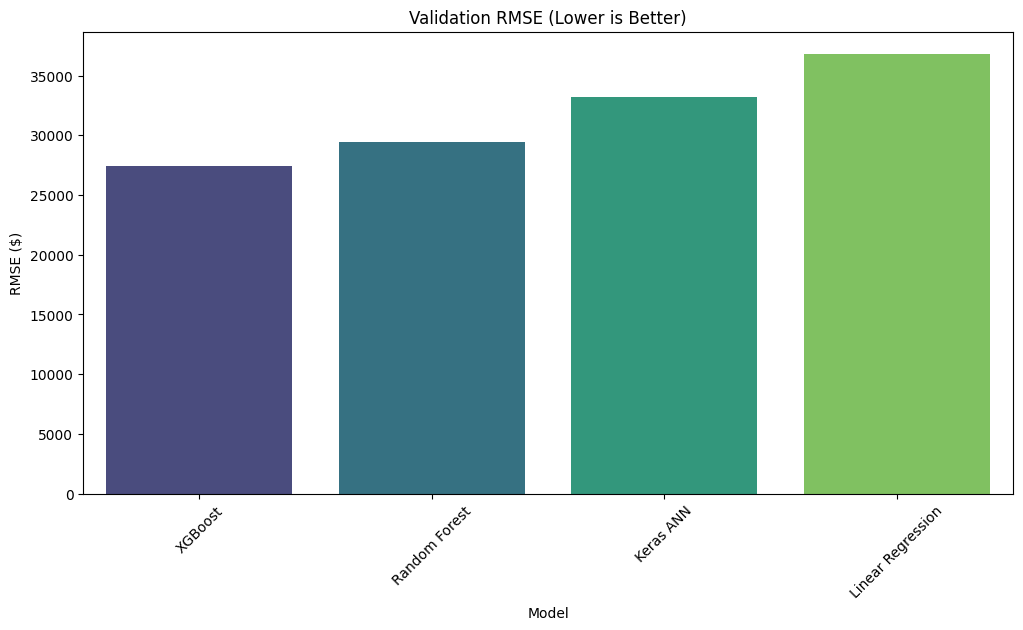

In [11]:
# plot 1: RMSE comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Val RMSE', data=df_comparison, palette='viridis')
plt.title('Validation RMSE (Lower is Better)')
plt.xlabel('Model')
plt.ylabel('RMSE ($)')
plt.xticks(rotation=45)
plt.show()

## 8. Summary Table

In [12]:
# Display nice summary table
summary_df = df_comparison.copy()
summary_df['Val RMSE'] = summary_df['Val RMSE'].apply(lambda x: f"${x:,.2f}")
summary_df['Train RMSE'] = summary_df['Train RMSE'].apply(lambda x: f"${x:,.2f}")
summary_df['Val MAE'] = summary_df['Val MAE'].apply(lambda x: f"${x:,.2f}")
summary_df['Train MAE'] = summary_df['Train MAE'].apply(lambda x: f"${x:,.2f}")
summary_df['Val R2'] = summary_df['Val R2'].apply(lambda x: f"{x:.4f}")
summary_df['Train R2'] = summary_df['Train R2'].apply(lambda x: f"{x:.4f}")

from IPython.display import display, HTML

# Style the dataframe
styled_df = summary_df.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt'
}).set_table_styles([
    {
        'selector': 'th',
        'props': [('font-size', '14pt'), ('font-weight', 'bold'), ('text-align', 'center')]
    }
])

display(styled_df)


,Model,Train RMSE,Val RMSE,Train MAE,Val MAE,Train R2,Val R2
1,XGBoost,"$2,327.45","$27,449.09","$1,722.61","$17,430.36",0.9991,0.9018
0,Random Forest,"$14,014.84","$29,449.83","$7,875.44","$18,149.89",0.9671,0.8869
2,Keras ANN,"$22,337.95","$33,191.32","$14,161.31","$20,578.17",0.9163,0.8564
3,Linear Regression,"$33,920.14","$36,836.91","$21,066.67","$22,975.86",0.8071,0.8231


In [13]:
# Print top 10 features for each model
print("\n" + "="*80)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*80)

models_dict = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
}

for model_name, model in models_dict.items():
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': numerical_features,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(10)

    print(f"\n{model_name}:")
    for i, row in importance_df.iterrows():
        print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")



TOP 10 MOST IMPORTANT FEATURES

Random Forest:
  OverallQual                   : 0.5737
  GrLivArea                     : 0.1273
  TotalBsmtSF                   : 0.0385
  BsmtFinSF1                    : 0.0335
  2ndFlrSF                      : 0.0314
  1stFlrSF                      : 0.0295
  LotArea                       : 0.0215
  GarageArea                    : 0.0181
  YearBuilt                     : 0.0176
  GarageCars                    : 0.0164

XGBoost:
  OverallQual                   : 0.5258
  GarageCars                    : 0.1155
  GrLivArea                     : 0.0771
  BsmtFinSF1                    : 0.0283
  2ndFlrSF                      : 0.0273
  PoolArea                      : 0.0215
  Fireplaces                    : 0.0206
  TotalBsmtSF                   : 0.0171
  YearBuilt                     : 0.0163
  KitchenAbvGr                  : 0.0144


## Extract Top 10 XGBoost Features

### Subtask:
Extract the names of the top 10 most important features from the previously trained XGBoost model's feature importances. This will fix the KeyError encountered before.


In [14]:
top_10_xgb_features = importance_df['Feature'].tolist()
print(f"Top 10 XGBoost Features: {top_10_xgb_features}")

Top 10 XGBoost Features: ['OverallQual', 'GarageCars', 'GrLivArea', 'BsmtFinSF1', '2ndFlrSF', 'PoolArea', 'Fireplaces', 'TotalBsmtSF', 'YearBuilt', 'KitchenAbvGr']


In [15]:
X_train_top10 = X_train[top_10_xgb_features]
X_val_top10 = X_val[top_10_xgb_features]
X_test_top10 = X_test_full[top_10_xgb_features]

print(f"X_train_top10 shape: {X_train_top10.shape}")
print(f"X_val_top10 shape: {X_val_top10.shape}")

# Train XGBoost model on top 10 features
xgb_top10 = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)
xgb_top10.fit(X_train_top10, y_train)

# Make predictions
xgb_top10_pred_train = xgb_top10.predict(X_train_top10)
xgb_top10_pred_val = xgb_top10.predict(X_val_top10)

# Evaluate model
xgb_top10_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_top10_pred_train))
xgb_top10_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_top10_pred_val))
xgb_top10_train_r2 = r2_score(y_train, xgb_top10_pred_train)
xgb_top10_val_r2 = r2_score(y_val, xgb_top10_pred_val)
xgb_top10_train_mae = mean_absolute_error(y_train, xgb_top10_pred_train)
xgb_top10_val_mae = mean_absolute_error(y_val, xgb_top10_pred_val)

print(f"\nXGBoost Top 10 Features Results:")
print(f"  Train RMSE: ${xgb_top10_train_rmse:,.2f}")
print(f"  Val RMSE: ${xgb_top10_val_rmse:,.2f}")
print(f"  Train R²: {xgb_top10_train_r2:.4f}")
print(f"  Val R²: {xgb_top10_val_r2:.4f}")
print(f"  Train MAE: ${xgb_top10_train_mae:,.2f}")
print(f"  Val MAE: ${xgb_top10_val_mae:,.2f}")

# Make predictions on test set
xgb_top10_pred_test = xgb_top10.predict(X_test_top10)

X_train_top10 shape: (1168, 10)
X_val_top10 shape: (292, 10)

XGBoost Top 10 Features Results:
  Train RMSE: $5,955.75
  Val RMSE: $28,697.98
  Train R²: 0.9941
  Val R²: 0.8926
  Train MAE: $4,358.09
  Val MAE: $19,011.55


In [16]:
xgboost_top10_data = {
    'Model': 'XGBoost (Top 10 Features)',
    'Train RMSE': xgb_top10_train_rmse,
    'Val RMSE': xgb_top10_val_rmse,
    'Train MAE': mean_absolute_error(y_train, xgb_top10_pred_train),
    'Val MAE': mean_absolute_error(y_val, xgb_top10_pred_val),
    'Train R2': xgb_top10_train_r2,
    'Val R2': xgb_top10_val_r2
}

df_comparison_top10 = pd.DataFrame([xgboost_top10_data])

# Filter out the original XGBoost entry and append the new one for comparison
df_comparison_updated = df_comparison[df_comparison['Model'] != 'XGBoost'].copy()
df_comparison_updated = pd.concat([df_comparison_updated, df_comparison_top10], ignore_index=True)
df_comparison_updated = df_comparison_updated.sort_values('Val RMSE').reset_index(drop=True)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS (INCLUDING XGBoost Top 10 Features)")
print("="*80)
print(df_comparison_updated.to_string(index=False))

# Find best model from updated comparison
best_model_idx_updated = df_comparison_updated['Val RMSE'].idxmin()
best_model_updated = df_comparison_updated.loc[best_model_idx_updated, 'Model']
best_rmse_updated = df_comparison_updated.loc[best_model_idx_updated, 'Val RMSE']
best_r2_updated = df_comparison_updated.loc[best_model_idx_updated, 'Val R2']

print("\n" + "="*80)
print(f"  BEST MODEL: {best_model_updated}")
print(f"   Validation RMSE: ${best_rmse_updated:,.2f}")
print(f"   Validation R-squared Score: {best_r2_updated:.4f}")
print("="*80)



MODEL COMPARISON RESULTS (INCLUDING XGBoost Top 10 Features)
                    Model   Train RMSE     Val RMSE    Train MAE      Val MAE  Train R2   Val R2
XGBoost (Top 10 Features)  5955.747812 28697.977072  4358.094727 19011.550781  0.994053 0.892629
            Random Forest 14014.836814 29449.829501  7875.436707 18149.893840  0.967069 0.886929
                Keras ANN 22337.950488 33191.320311 14161.308594 20578.167969  0.916342 0.856373
        Linear Regression 33920.135629 36836.908846 21066.668644 22975.856509  0.807098 0.823090

  BEST MODEL: XGBoost (Top 10 Features)
   Validation RMSE: $28,697.98
   Validation R-squared Score: 0.8926


In [17]:
#Gradio interface
import gradio as gr

# Calculate average percentage error on validation set
percentage_errors = np.abs((y_val -xgb_top10_pred_val) / y_val) * 100
avg_percentage_error = np.mean(percentage_errors)
avg_accuracy_percentage = 100 - avg_percentage_error

# Prediction function
def predict_house_price(*args):
  # Create dataframe from user inputs
  input_data = pd.DataFrame([args], columns=top_10_xgb_features)

  # Make prediction
  prediction = xgb_top10.predict(input_data)[0]

  # Calculate prediction accuracy% using MAPE(Mean Absolute Percentage Error)
  expected_error_percentage = (xgb_top10_val_mae / prediction) * 100
  prediction_accuracy = 100 - expected_error_percentage

  # Ensure accuracy is within reasonable bounds
  prediction_accuracy = max(0, min(100, prediction_accuracy))

  # Format the predicted price output with accuracy
  price_output = f"${prediction:,.2f}\n\n🎯 Prediction Accuracy: {prediction_accuracy:.1f}%"

  # Format detailed accuracy text
  accuracy_text = f"""

🎯 **This Prediction Accuracy:** {prediction_accuracy:.1f}%
- Expected error range: ±${xgb_top10_val_mae:,.2f} (±{expected_error_percentage:.1f}%)
- Predicted price range: ${prediction - xgb_top10_val_mae:,.2f} → ${prediction + xgb_top10_val_mae:,.2f}

✅ **Confidence Level:** {"HIGH" if prediction_accuracy >= 90 else "MEDIUM" if prediction_accuracy >= 80 else "MODERATE"}
"""
  return price_output, accuracy_text


In [18]:
#Create gradio interface

#Feature name mapping for user-friendly display
feature_labels = {
    'OverallQual': '⭐ Overall Quality (1-10)',
    'GarageCars': '🚗 Garage Capacity (Cars)',
    'GrLivArea': '🏠 Living Area (sq ft)',
    'BsmtFinSF1': '🔨 Finished Basement Area (sq ft)',
    '2ndFlrSF': '⬆️ Second Floor Area (sq ft)',
    'PoolArea': '🏊 Pool Area (sq ft)',
    'Fireplaces': '🔥 Number of Fireplaces',
    'TotalBsmtSF': '📦 Total Basement Area (sq ft)',
    'YearBuilt': '📅 Year Built',
    'KitchenAbvGr': '👨‍🍳 Kitchens Above Ground'
}
# Determine dataset for slider initialization
slider_data = (X_train_top10)

# Create sliders with friendly labels
sliders = [
    gr.Slider(
        minimum=float(slider_data[f].min()),
        maximum=float(slider_data[f].max()),
        value=float(slider_data[f].median()),
        label=feature_labels.get(f, f),
        info=f"Range: {slider_data[f].min():.0f} - {slider_data[f].max():.0f}"
    ) for f in top_10_xgb_features
]

with gr.Blocks(theme=gr.themes.Monochrome(), title="House Price Predictor") as demo:

    gr.Markdown("""
<div style="text-align: center;">
<h1 style="font-size: 50px; margin-bottom: 10px;">House Price Prediction System 🏡</h1>
<h3 style="font-size: 24px; margin-top: 0;">Powered by XGBoost Machine Learning Model</h3>
</div>
""")

    with gr.Row():
        with gr.Column():
            gr.Markdown("## House Features")
            # Render the sliders
            for slider in sliders:
                slider.render()

        with gr.Column():
            gr.Markdown("## 💰 Prediction Results")
            predict_btn = gr.Button("Predict Price", variant="primary", size="lg")
            predicted_price = gr.Textbox("Predicted House Price & Accuracy", interactive=False, lines=3)
            accuracy_output = gr.Markdown("*Click 'Predict Price' to see detailed accuracy metrics*")

    gr.Markdown("""
    ---
    ### 📖 How to Use
    Adjust sliders → Predict → Review accuracy
    """)

    # Connect prediction function
    predict_btn.click(predict_house_price, inputs=sliders, outputs=[predicted_price, accuracy_output])


In [19]:
#LAUNCH INTERFACE

print("=" * 60)
print("LAUNCHING GRADIO INTERFACE...")
print("=" * 60)

demo.launch(share=True)

LAUNCHING GRADIO INTERFACE...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://19dbe5ef849128791d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
